#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Directories + Hyperparameters

In [2]:
train_dir = 'train'
test_dir = 'test'
    
img_size = 48
batch_size = 64
seed = 15
epochs = 20
num_classes = 0

class_labels = []

for num_classes, label in enumerate(os.listdir(train_dir)):
    num_classes += 1
    class_labels.append(label)
    
print(class_labels)
print(f"Num of class: {num_classes}")



['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Num of class: 7


#### Data Visualization

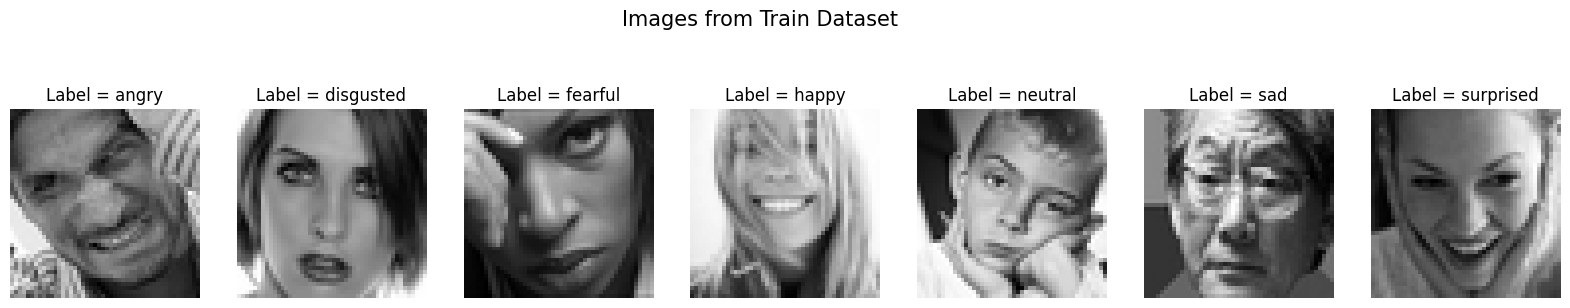

In [3]:
fig, axes = plt.subplots(1, 7, figsize=(20, 4))
fig.suptitle('Images from Train Dataset', fontsize=15)

axes = axes.flatten()

for i, label in enumerate(os.listdir(train_dir)):
    if i == len(axes):
        break
    
    label_path = os.path.join(train_dir, label)
    
    if os.path.isdir(label_path):
        img_file = [f for f in os.listdir(label_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if img_file:
            random_img = random.choice(img_file)
            
            img_path = os.path.join(label_path, random_img)
            
            img = mpimg.imread(img_path)
            
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Label = {label}")
            axes[i].axis('off')

plt.show()

C:\Users\Naman\AppData\Roaming\Python\Python310\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Naman\AppData\Roaming\Python\Python310\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Naman\AppData\Roaming\Python\Python310\site-packages\seaborn\_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Naman\AppData\Roaming\Python\Python310\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dty

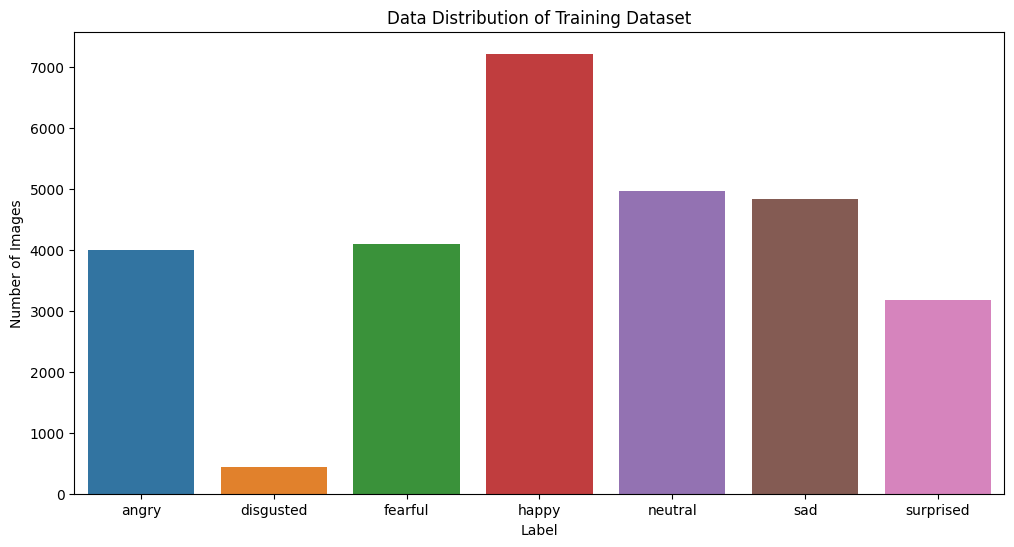

In [4]:
label_cnt = {}

for label in class_labels:
    label_path = os.path.join(train_dir, label)
    num_img = len([f for f in os.listdir(label_path)])
    label_cnt[label] = num_img

plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_cnt.keys()), y=list(label_cnt.values()))
plt.title('Data Distribution of Training Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.show()

#### Pre-processing

In [5]:
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image

In [6]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )

validation_generator = validation_datagen.flow_from_directory(directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


#### Model

In [7]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Flatten
from tensorflow.keras import Sequential
from keras import regularizers

In [8]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)),
    Conv2D(64,(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(128,(5,5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    Dense(512,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

#### Training

In [9]:
history = model.fit(x=train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
351/359 [============================>.] - ETA: 29s - loss: 5.4884 - accuracy: 0.2291

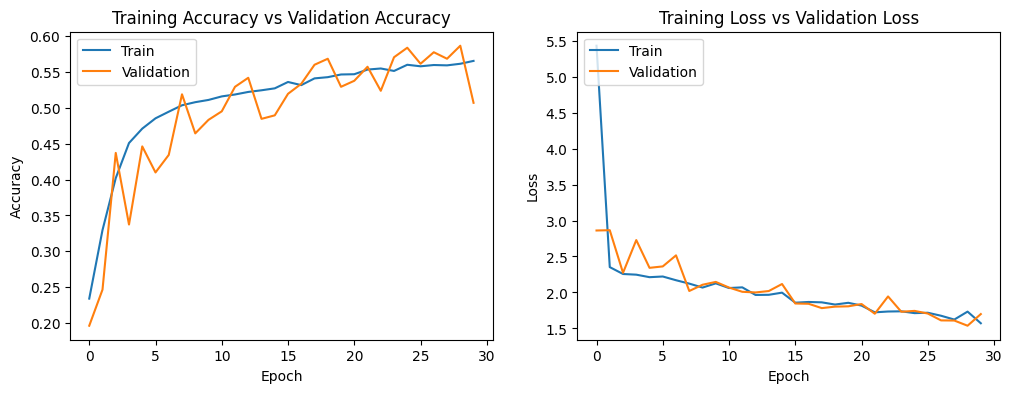

In [11]:
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

#### Testing

In [12]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

1/1 [==============================] - 0s 285ms/step
Fear


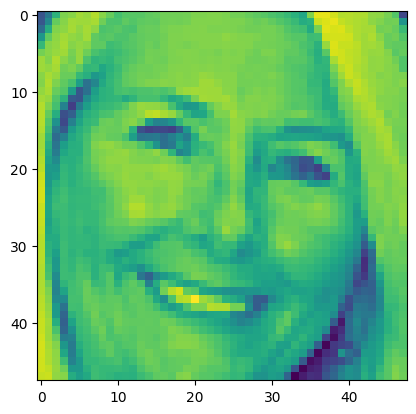

In [13]:
img = image.load_img("/kaggle/input/emotion-detection-fer/test/happy/im1003.png",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)

img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])

img_index = result.index(max(result))
print(label_dict[img_index])

In [14]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(validation_generator)
print("train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 1s 57ms/step - loss: 1.6995 - accuracy: 0.5070
train accuracy = 49.94 , validation accuracy = 50.70


#### Saving Model

In [15]:
model.save('model_1.h5')
model.save_weights('model_weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
